In [1]:
import os

import cmcrameri.cm as cmc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import math
import pickle


In [2]:
combined = pd.read_csv('/home/earthquakes1/homes/Rebecca/phd/stf/data/combined.csv')

In [3]:
def get_isc_stf(isc_name):
    isc_save_path = '/home/earthquakes1/homes/Rebecca/phd/stf/data/isc/'
    with open(f'{isc_save_path}{isc_name}/{isc_name}.txt', 'rb') as f:
        stf_list = pickle.load(f)
    with open(f'{isc_save_path}{isc_name}/{isc_name}_norm_info.txt', 'rb') as f:
        norm_dict = pickle.load(f)

    time = np.arange(0, 25.6, 0.1)
    momentrate = np.array(stf_list)*norm_dict['mo_norm']*10**8,
    return momentrate, time

In [4]:
def get_scardec_stf(scardec_name, wanted_type = 'fctopt'):
    time = []
    momentrate = []

    event = os.listdir(f'/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec/{scardec_name}')
    starts = [n for n, l in enumerate(event) if l.startswith(wanted_type)]
    with open(f'/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec/{scardec_name}/{event[starts[0]]}') as f:
        lines = f.read().splitlines()

    lines = lines[2:]
    for line in lines:
        split = line.split(' ')
        split = [s for s in split if s not in ['', ' ', '\n']]
        time.append(float(split[0]))
        momentrate.append(float(split[1]))

    momentrate = np.array(momentrate)
    time = np.array(time)
    return momentrate, time

In [5]:
def get_usgs_stf(usgs_name):
    data_path = '/home/earthquakes1/homes/Rebecca/phd/stf/data/USGS/'
    momentrate = []
    time = []

    with open(data_path + str(usgs_name), 'r') as f:
        data = f.readlines()
        for line in data:
            line = line.strip()
            line = line.rstrip()
            if line[0] not in ['0','1','2','3','4','5','6','7','8','9']:
                continue
            line = line.split()
            time.append(float(line[0]))
            momentrate.append(float(line[1]))

    momentrate = np.array(momentrate)
    time = np.array(time)

    momentrate = momentrate / 10**7 # convert to Nm from dyne cm
    return momentrate, time

In [6]:
def find_end_stf(momentrate, time):
    not_zero = np.where(momentrate > 0)[0]
    #print(max(momentrate))
    start = min(not_zero)
    end = max(not_zero)

    detected_end = end
    detected_end_time = time[end]

    time = time[:end]
    momentrate = momentrate[:end]

    less_than_10 = np.where(momentrate <= 10*max(momentrate)/100)[0]
    #print(less_than_10)
    total_moment = scipy.integrate.simpson(momentrate[0:end],
                                        dx = time[1]-time[0])
    #print(less_than_10)
    for i in less_than_10:
        if i == 0:
            continue
        moment = scipy.integrate.simpson(momentrate[0:i],
                                        dx = time[1]-time[0])
        #print(i, moment/total_moment)
        if moment >= 0.5 * total_moment:
            #print('inif')
            #print(f'first time where < 10% of total momentrate and 50% of moment released: {time[i]} s')
            detected_end_time = time[i]
            detected_end = i
            #print(f'proportion of moment released: {(moment/total_moment)*100:.2f}%')
            break
    return detected_end_time, detected_end, time[start], start
    #return time[end], end

In [7]:
# looks for time value of root
def f3(end_time, total_moment, time_opt, momentrate_opt, start, points_before_zero, proportion = 0.1):

    dx = time_opt[1]-time_opt[0]
    end_window = (end_time/dx)+points_before_zero
    end = int(np.floor(end_window))
    #print(start, end)
    if start == end:
        end += 1
    short = scipy.integrate.simpson(momentrate_opt[start:end], dx = dx)
    return short-(total_moment*proportion)

In [8]:
def plot_scatter_figures(proportion, root_times, moments, durations):
    root_times = np.array(root_times)
    moments = np.array(moments)
    durations = np.array(durations)

    plt.scatter(root_times, durations, c = np.log10(moments), cmap = cmc.batlow, alpha = 0.5)
    plt.ylabel('Duration (s)')
    plt.xlabel(f'time to release {proportion*100}% of moment (s)')
    plt.colorbar(label = 'log10(moment)')
    plt.savefig(f'/home/earthquakes1/homes/Rebecca/phd/stf/figures/moment_intervals/time_for_{proportion*100}_percent_moment_against_duration.png')
    plt.close()

    plt.scatter(root_times, np.log10(moments), c = durations, cmap = cmc.batlow, alpha = 0.5)
    plt.ylabel('log10(moment)')
    plt.xlabel(f'time to release {proportion*100}% of moment (s)')
    plt.colorbar(label = 'Duration (s)')
    plt.savefig(f'/home/earthquakes1/homes/Rebecca/phd/stf/figures/moment_intervals/time_for_{proportion*100}_percent_moment_against_moment.png')
    plt.close()

    plt.scatter(root_times/durations, np.log10(moments), c = durations, cmap = cmc.batlow, alpha = 0.5)
    plt.ylabel('log10(moment)')
    plt.xlabel(f'proportion of duration to release {proportion*100}% of moment')
    plt.colorbar()
    plt.xlim(0, 1)
    plt.savefig(f'/home/earthquakes1/homes/Rebecca/phd/stf/figures/moment_intervals/fraction_of_duration_for_{proportion*100}_percent_moment_against_moment.png')
    plt.close()

In [9]:
def plot_hist_figures(proportion, root_times, durations):
    root_times = np.array(root_times)
    durations = np.array(durations)

    plt.hist(root_times/durations, bins = 100)

    plt.ylabel('Frequency')
    plt.xlabel(f'Proportion of duration to release {proportion*100}% of moment')
    plt.xlim(0, 1)
    plt.show()
    #plt.savefig(f'/home/earthquakes1/homes/Rebecca/phd/stf/figures/moment_intervals/histogram_fraction_of_duration_for_{proportion*100}_percent_moment.png')
    #plt.close()

In [10]:
combined = pd.read_csv('/home/earthquakes1/homes/Rebecca/phd/stf/data/combined_scardec_ye_usgs_sigloch_isc_mag.csv')
combined.columns = ['event', 'scardec', 'ye', 'isc', 'sigloch', 'usgs', 'mag']

In [21]:
proportions_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

all_durations = []
all_root_times = []
all_moments = []
all_relative_root_times = [[]]

all_relative_root_times_for_event = {}

for proportion in proportions_list:
    print(proportion)
    durations = []
    root_times = []
    relative_root_times = []

    diff = []
    moments = []

    for i, row in combined.iterrows():
        name = row['isc']
        if name == '0' or name == 0:
            continue
        #print(scardec_name)
        momentrate, time = get_isc_stf(name)
        momentrate = momentrate[0]

        detected_end_time, detected_end, detected_start_time, detected_start = find_end_stf(momentrate, time)
        time = time - detected_start_time # shift to start STF at zero
        detected_end_time = detected_end_time - detected_start_time

        not_zero = np.where(momentrate > 0)[0]

        dx = time[1]-time[0]

        start = 0 # min(not_zero)
        end = detected_end - detected_start # max(not_zero)
        points_before_zero = 0 # abs(min(time)/dx)

        duration = detected_end_time
        durations.append(duration)

        start_time = 0
        end_time = detected_end_time

        total_moment = scipy.integrate.simpson(momentrate[0:end], dx = dx)
        moments.append(total_moment)
        try:
            root, r = scipy.optimize.bisect(f3,
                                            start_time+dx,
                                            end_time-dx,
                                            rtol = 1e-6,
                                            full_output = True,
                                            args = (total_moment,
                                                    time,
                                                    momentrate,
                                                    start,
                                                    points_before_zero,
                                                    proportion,))
        except ValueError:
            print('value error')
            print(name)
            durations = durations[:-1]
            continue
        root_idx = np.floor(root/dx)
        root_time = root_idx*dx
        root_times.append(root_time)
        relative_root_times.append(root_time-start_time)

        save_key = row['event']

        if save_key in all_relative_root_times_for_event.keys():
            to_save = all_relative_root_times_for_event[save_key]
            to_save.append((root_time-start_time)/duration)
            all_relative_root_times_for_event[save_key] = to_save
        else:
            all_relative_root_times_for_event[save_key] = [(root_time-start_time)/duration]


        if root_time-start_time > duration:
            print('root time greater than duration, proportion:', proportion)
            print(name)

    root_times = np.array(root_times)
    print(root_times)
    durations = np.array(durations)
    moments = np.log10(np.array(moments))
    relative_root_times = np.array(relative_root_times)

    rel_root_times = relative_root_times/durations
    all_root_times.append(root_times[0])
    all_relative_root_times.append(list(rel_root_times))


0.1
[0.9 1.9 1.3 1.2 2.4 1.8 2.5 0.9 1.1 0.6 1.2 1.1 1.3 1.4 1.6 1.  2.1 1.2
 1.1 3.3 0.7 1.  2.9 1.1 2.9 1.9 0.9 1.3 1.1 1.3 2.7 1.1 1.2 1.2 1.3 1.8
 0.9 1.1 2.2 0.7 2.  0.9 1.8 1.4 1.  1.1 1.  1.4 1.2 2.4 1.  1.4 1.2 3.5
 1.2 1.3 1.1 1.9 1.5 1.4 1.1 1.1 1.  1.  1.7 1.  0.9 1.3 1.8 1.  0.8 1.6
 1.2 0.9 0.9 0.9 1.8 0.9 0.8 1.3 1.  3.3 0.6 1.9 1.1 1.6 1.6 1.  1.  2.
 0.9 2.6 1.2 1.4 3.7 2.7 1.1 0.9 1.5 1.  1.8 1.3 0.7 1.  1.  1.3 1.2 1.1
 1.1 1.4 1.1 2.9 1.3 1.9 1.  1.6 2.3 1.  1.2 1.  1.7 3.9 1.2 1.2 1.1 1.2
 1.2 1.1 1.4 1.4 0.9 1.4 1.2 1.5 1.4 1.4 1.  0.9 1.3 1.1 1.2 0.8 4.1 1.3
 2.8 2.3 1.1 1.4 1.  1.  0.9 1.1 1.  1.1 1.1 0.9]
0.2
[1.4 3.6 1.7 1.8 3.1 2.3 3.7 2.5 3.1 0.8 1.7 2.2 1.9 1.9 2.1 1.5 3.  3.3
 1.7 4.2 1.1 1.7 3.8 1.9 4.2 2.3 1.2 2.4 3.2 1.9 3.8 2.4 1.7 2.5 1.9 2.6
 1.4 2.3 3.9 1.1 3.1 1.6 2.1 2.1 1.5 1.8 1.5 2.4 2.5 3.4 1.7 3.2 1.6 4.7
 1.7 3.3 3.7 3.5 1.9 1.8 3.4 2.  2.6 1.9 2.  1.8 3.4 2.1 2.3 1.6 1.3 3.2
 1.9 1.5 1.5 1.4 2.4 3.4 1.2 1.8 1.5 4.5 0.9 3.5 1.5 3.4 1.9 1.6 1.

In [15]:
df = pd.DataFrame.from_dict(all_relative_root_times_for_event, orient='index', columns=['10', '20', '30', '40', '50', '60', '70', '80', '90'])

In [17]:
df.to_csv('/home/earthquakes1/homes/Rebecca/phd/stf/data/isc_relative_root_times.csv')

In [13]:
df = pd.read_csv('/home/earthquakes1/homes/Rebecca/phd/stf/data/isc_relative_root_times.csv')

In [14]:
def gaussian(x, mu = 0, sigma = 1):
    return (1/(sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma)**2)

In [15]:
def triangle(x):
    x = np.array(x)
    y = np.zeros(len(x))
    m = 1/(abs(x[0]-x[int(len(x)/2)]))
    print(m)
    y[:int(len(x)/2)] = m*x[:int(len(x)/2)]
    y[int(len(x)/2):] = -m*x[int(len(x)/2):]
    y[:int(len(x)/2)] = y[:int(len(x)/2)] - min(y[:int(len(x)/2)])
    y[int(len(x)/2):] = y[int(len(x)/2):] - min(y[int(len(x)/2):])

    return y

In [16]:
def boxcar(x):
    y = np.zeros(len(x))
    y = y + 1
    return y

In [17]:
def trapezium(x, start = 0.3333, end = 0.3333):
    length = len(x)
    start_index = int(length*start)
    end_index = int(length*end)
    print(length, start_index, end_index)

    y = np.zeros(length)

    y[:start_index] = np.linspace(0, 1, start_index)
    y[start_index:length-end_index] = 1
    y[length-end_index:] = 1 - np.linspace(0, 1, end_index)
    return y


In [18]:
def sine_boxcar(x, start = 0.3333, end = 0.3333):
    length = len(x)
    start_index = int(length*start)
    end_index = int(length*end)
    print(length, start_index, end_index)

    y = np.zeros(length)

    y[:start_index] = np.sin(np.linspace(-math.pi/2, math.pi/2, start_index))
    y[start_index:length-end_index] = 1
    y[length-end_index:] = (np.sin(np.linspace(-math.pi/2, math.pi/2, start_index)))[::-1]
    return y

In [19]:
def comparison_calculation(funct):
    proportions_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

    #print(proportion)
    durations = []
    g_root_times = []
    g_relative_root_times = []


    for proportion in proportions_list:

        diff = []
        moments = []


        # Generate x values
        x = np.linspace(-4, 4, 100)

        # Generate y values
        y = funct(x)

        # Use the generated Gaussian values
        momentrate_opt, time_opt = y, x

        not_zero = np.where(momentrate_opt > 0)[0]

        dx = time_opt[1]-time_opt[0]

        start = min(not_zero)
        end = max(not_zero)
        points_before_zero = abs(min(time_opt)/dx)

        duration = time_opt[end] - time_opt[start]
        durations.append(duration)

        start_time = time_opt[start]
        end_time = time_opt[end]

        total_moment = scipy.integrate.simpson(momentrate_opt[start:end], dx = time_opt[1]-time_opt[0])
        moments.append(total_moment)
        g_root, r = scipy.optimize.bisect(f3,
                                        start_time+dx,
                                        end_time,
                                        rtol = 1e-6,
                                        full_output = True,
                                        args = (total_moment,
                                                time_opt,
                                                momentrate_opt,
                                                start,
                                                points_before_zero,
                                                proportion,))
        g_root_idx = np.floor(g_root/dx)
        g_root_time = g_root_idx*dx
        g_root_times.append(g_root_time)
        g_relative_root_times.append(g_root_time-start_time)

    g_relative_root_times = np.array(g_relative_root_times)
    return g_relative_root_times/durations

In [22]:
all_relative_root_times.append([])

In [18]:
for i in all_relative_root_times:
    for j in i:
        try:
            float(j)
            pass
        except:
            print(j)


23.070432223990906
0.14788738605122376
36.60323901708861
0.23463614754543982
49.29607051728497
0.316000452033878
60.413968225005746
0.3872690270833702
70.63258836597824
0.4527730023460143
81.01067557999751
0.5192992024358815
92.70980289952261
0.5942936083302731
106.03076795472954
0.679684409966215
123.63786709757866
0.7925504301126838
0.2475
0.2475
0.2475
0.2475
0.2475
0.2475
0.2475
0.2475
0.2475
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33


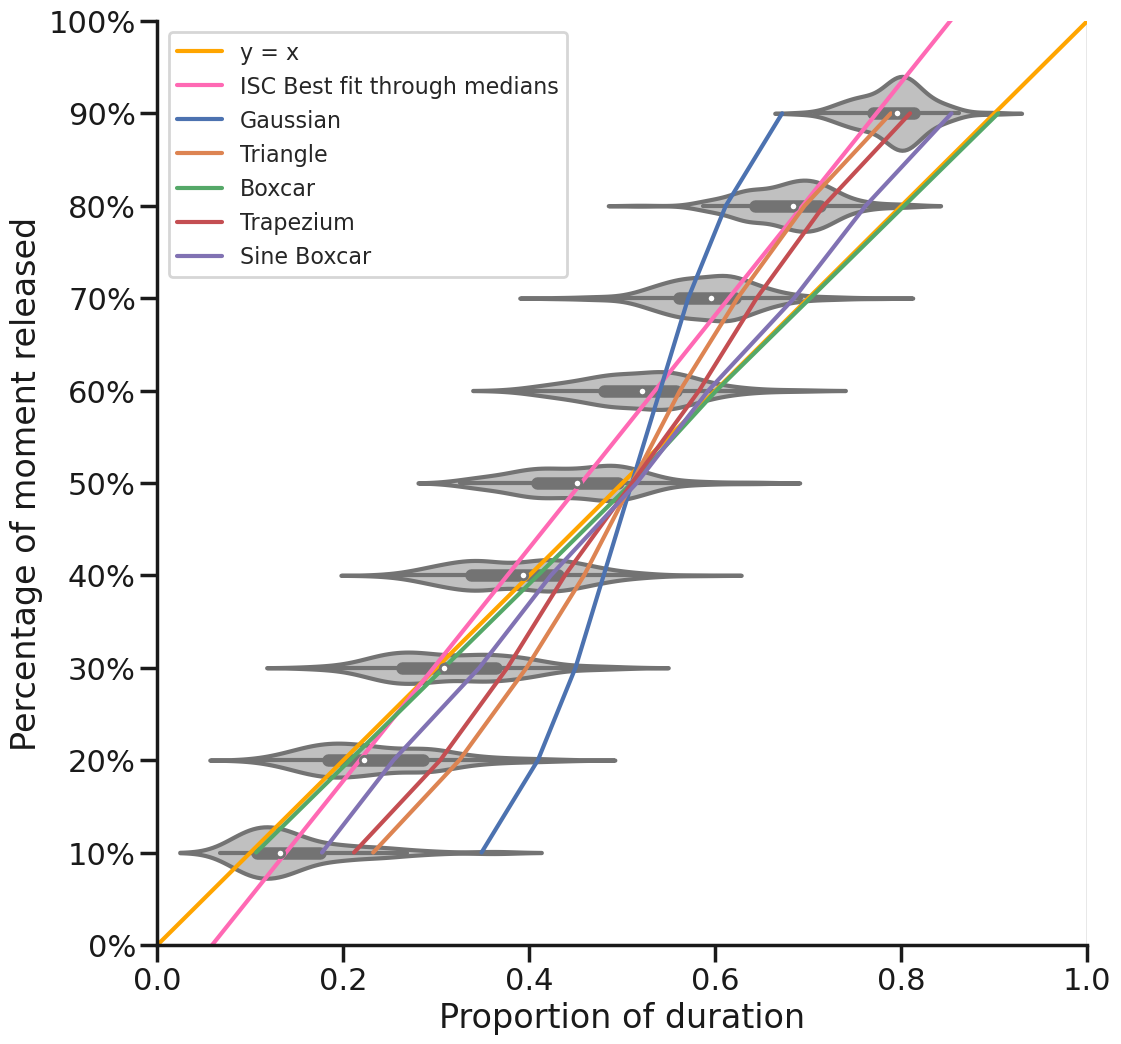

In [24]:
sns.set_theme(style="ticks", context="poster",rc={'figure.figsize':(10,10), "font.size":20})

sns.set_theme(style='ticks',
              context='poster',
              rc={'figure.figsize':(12,12),
                  'font.size':20})

params = {"ytick.color" : "k",
          "xtick.color" : "k",
          "axes.labelcolor" : "k",
          "axes.edgecolor" : "k"}
plt.rcParams.update(params)
plt.rc('legend',fontsize=16)


ax = sns.violinplot(data = all_relative_root_times,
               orient = 'h',
               color = 'silver')
ax.set_yticks(np.arange(len(np.arange(0, 1.1, 0.1))), [f'{p*100:.0f}%' for p in np.arange(0, 1.1, 0.1)])

ax.set_ylabel('Percentage of moment released')
ax.set_xlabel('Proportion of duration')

ax.invert_yaxis()

ax.plot(np.arange(0, 1.1, 0.1),
        np.arange(0, 11, 1),
        c = 'orange',
        label = 'y = x',)

means = []
medians = []
for i in all_relative_root_times[1:-1]:
    total = np.sum(i)
    print(total)
    mean = total/len(i)
    print(mean)
    means.append(mean)
    medians.append(np.median(i))

# Calculate the line of best fit
m, b = np.polyfit(means, np.arange(1, 10, 1), 1)
# Plot the line of best fit
# ax.plot(np.mean(all_relative_root_times[1:-1], axis=1),
#         m * np.mean(all_relative_root_times[1:-1], axis=1) + b,
#         c='red',
#         label = 'Mean LoBF',
#         linestyle = '--')

# Calculate the line of best fit
m, b = np.polyfit(medians, np.arange(1, 10, 1), 1)
# Plot the line of best fit
ax.plot(np.arange(0, 1, 0.1),
        m * np.arange(0, 1, 0.1) + b,
        c='hotpink',
        label = 'ISC Best fit through medians',
        linestyle = '-')


for funct, label in zip([gaussian, triangle, boxcar, trapezium, sine_boxcar], ['Gaussian', 'Triangle', 'Boxcar', 'Trapezium', 'Sine Boxcar']):
        ax.plot(comparison_calculation(funct), np.arange(1, 10, 1), label = label)

plt.ylim(-0, 10)
plt.xlim(0, 1)

ax.axvspan(1, 1.5, alpha = 0.2, color = 'grey')
plt.legend()
sns.despine()
plt.savefig('/home/earthquakes1/homes/Rebecca/phd/stf/figures/comparisons_to_predictions/violinplot_fraction_of_duration_for_percent_moment_isc_only_corrected_ends.png', dpi = 300)

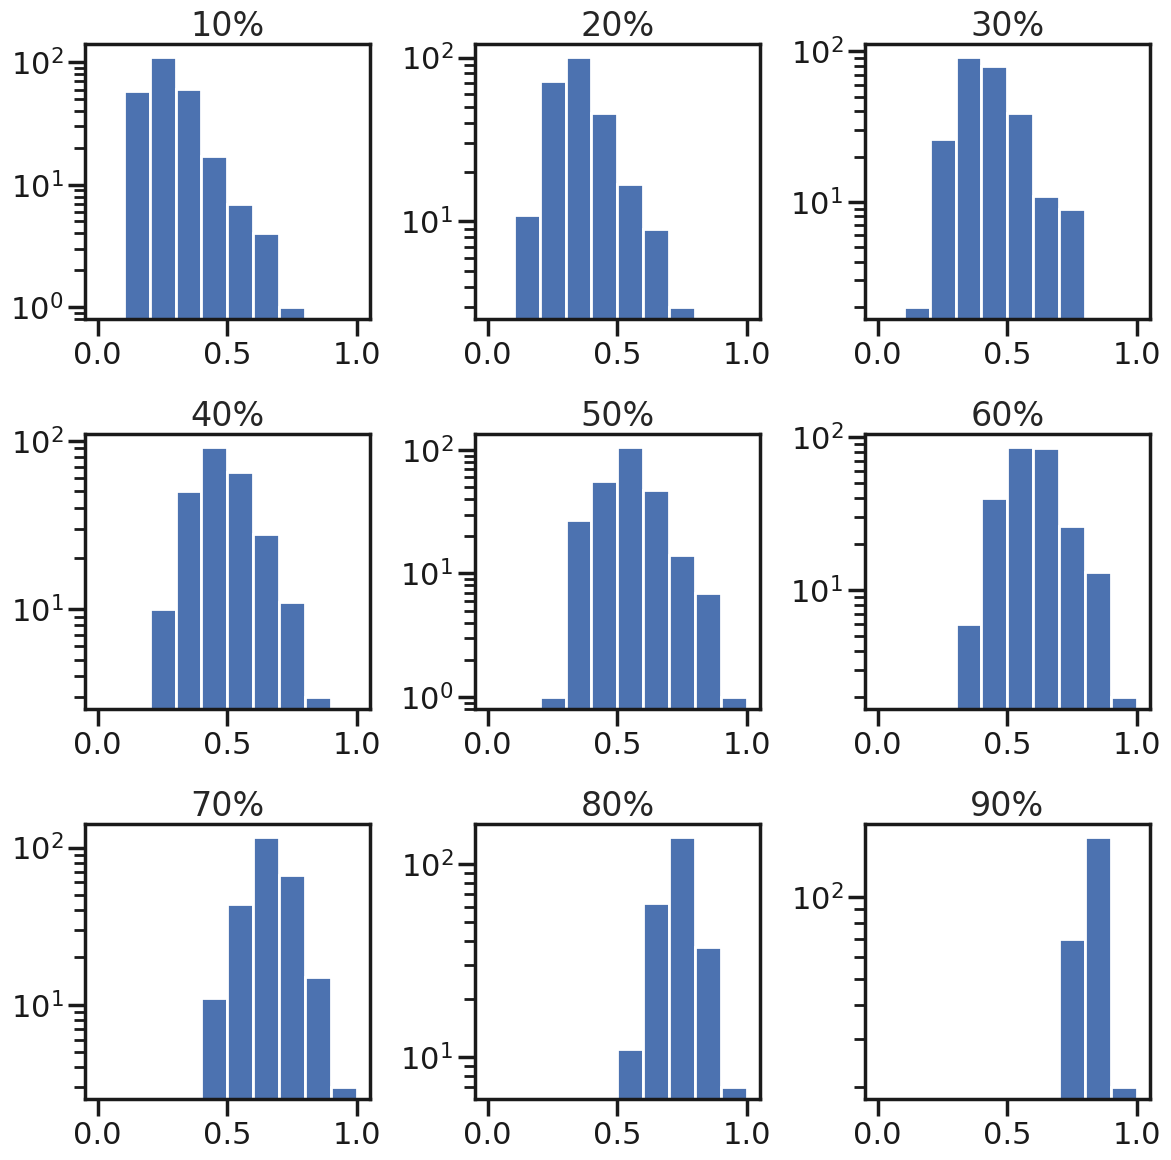

In [21]:
fig, axs = plt.subplots(3,3)
for i in range(9):
    ax = axs[i//3, i%3]
    ax.hist(all_relative_root_times[i+1], bins = np.arange(0 , 1.1, 0.1))
    ax.set_title(f'{proportions_list[i]*100:.0f}%')

    ax.set_yscale('log')

plt.tight_layout()
# plt.hist(all_relative_root_times[1:2])
# plt.yscale('log')

20101221_1719
20140401_2346
19940602_1817
20160829_0429
20160302_1249
20030715_2027
20180114_0918
20210213_1407
20150329_2348
19970421_1202
20130208_1526
20241110_1649


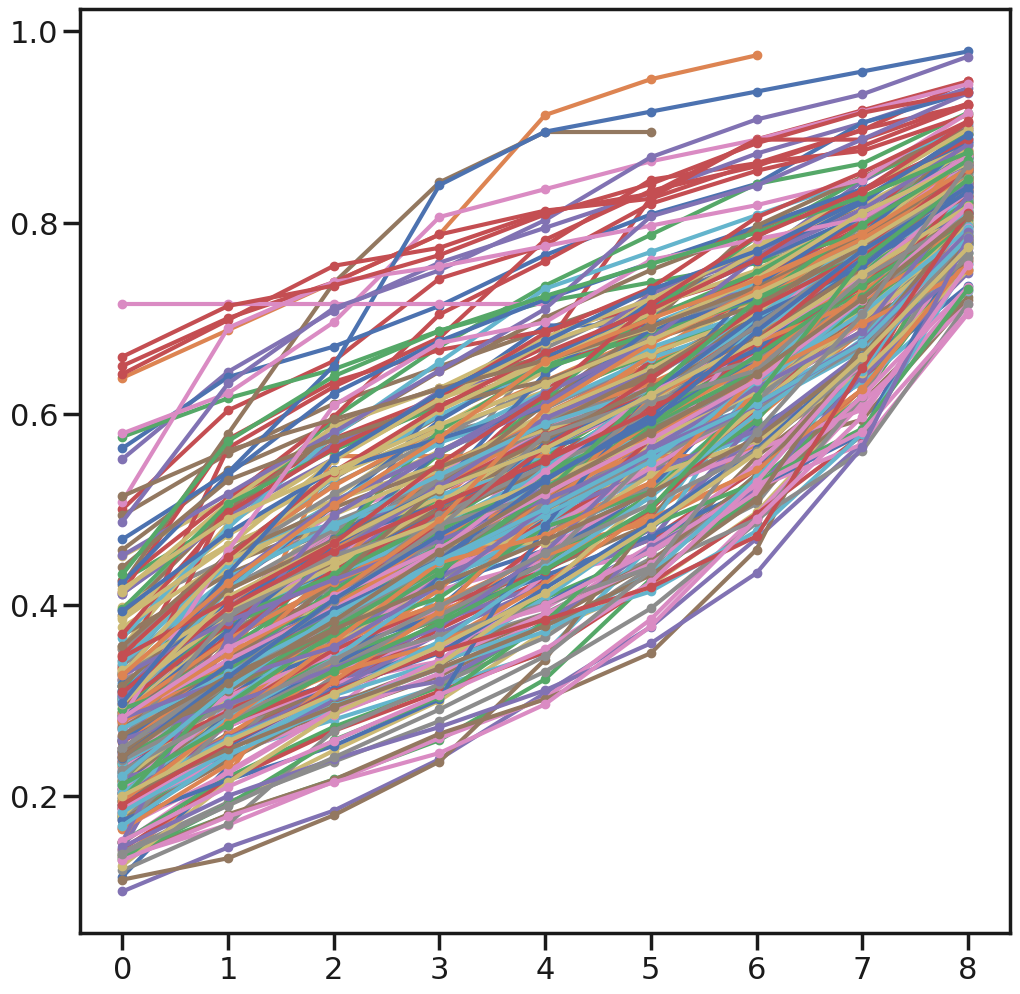

In [22]:
count = 0
for key in all_relative_root_times_for_event.keys():
    plt.plot(np.array(all_relative_root_times_for_event[key]), marker = '.')
    if all_relative_root_times_for_event[key][0] > 0.5:
        print(key)
    if all_relative_root_times_for_event[key][3] < 0.1:
        print(key)
    # count += 1
    # if count > 100:
    #     break
plt.show()